In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
df = pd.read_csv('train.csv')

In [20]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [21]:
df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Milling, Mr. Jacob Christian",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [22]:
df[['Pclass','Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [23]:
df[['Sex','Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [24]:
df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [85]:
df['Name_length'] = df['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# Create new feature IsAlone from FamilySize
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
df['Embarked'] = df['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
df['Title'] = df['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"

df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # Mapping Sex
sex_mapping = {'female': 0, 'male': 1}
df['Sex'] = df['Sex'].map(sex_mapping)
df['Sex'] = df['Sex'].fillna(0)
    # Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)
df['Title'] = df['Title'].fillna(0)
    
    # Mapping Embarked
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
df['Embarked'] = df['Embarked'].map(embarked_mapping)

    
    # Mapping Fare
df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare'] = 2
df.loc[ df['Fare'] > 31, 'Fare'] = 3
df['Fare'] = df['Fare'].astype(int)
    
    # Mapping Age

age_avg = df['Age'].mean()
age_std = df['Age'].std()
age_null_count = df['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
df['Age'][np.isnan(df['Age'])] = age_null_random_list
df['Age'] = df['Age'].astype(int)
df.loc[df['Age'] <= 16, 'Age'] = 0
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
df.loc[ df['Age'] > 64, 'Age'] = 4 ;

In [57]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,0,NaN,0,23,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,3,C85,1,51,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,3,C123,0,44,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,1,NaN,0,24,0,1,1,1


In [88]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'], axis=1, inplace=True)

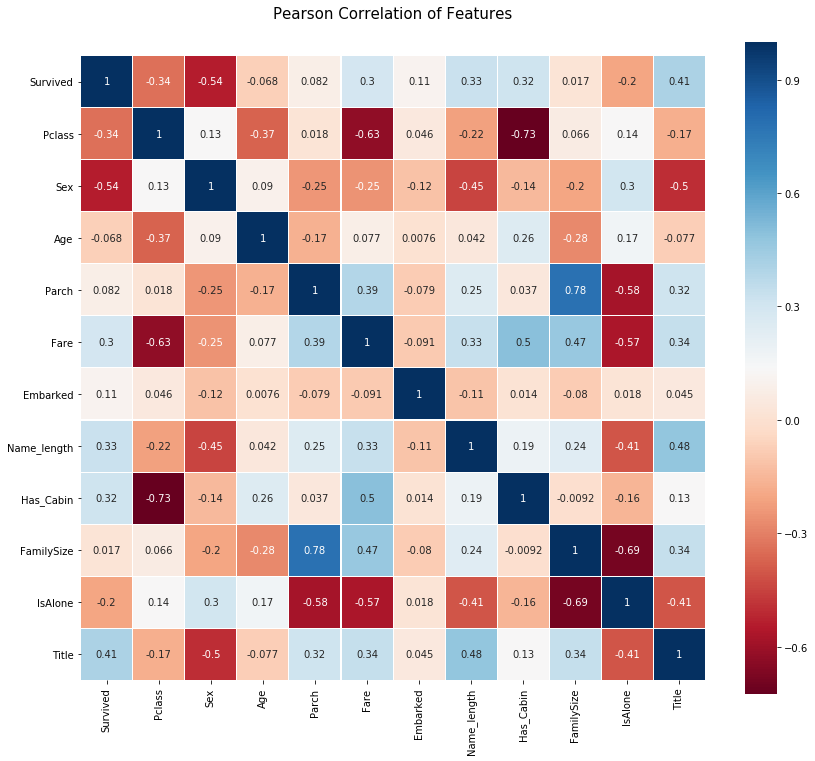

In [61]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

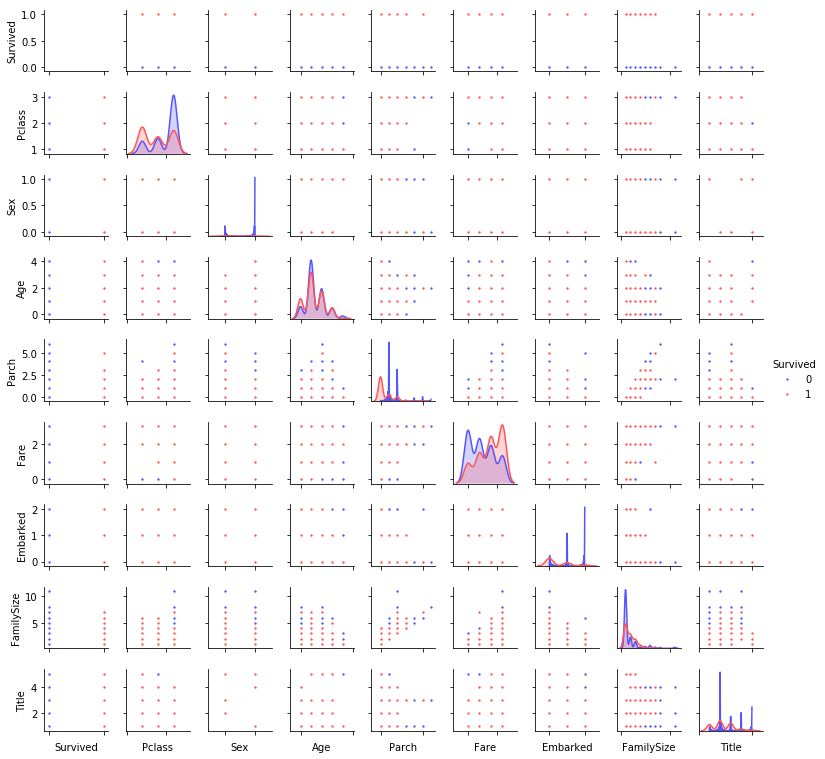

In [64]:
g = sns.pairplot(df[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [89]:
from sklearn.model_selection import train_test_split

y = df['Survived'].ravel()
X = df.drop(['Survived'], axis=1)
(X_train, 
 X_test, 
 y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=0)



In [90]:
gbm = xgb.XGBClassifier().fit(X_train, y_train)
predictions = gbm.predict(X_test)

In [91]:
from sklearn.metrics import roc_auc_score
roc_auc_xgboost = roc_auc_score(y_test, predictions)
roc_auc_xgboost

0.7914285714285714

In [92]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predict_rfc = rfc.predict(X_test)


In [93]:
roc_auc_rfc = roc_auc_score(y_test, predict_rfc)
roc_auc_rfc

0.7825